In [407]:
from torchvision import datasets
#from torchvision import transforms
import torchvision.transforms.v2 as transforms
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F

from torch.utils.data import DataLoader, random_split
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import sampler
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
import numpy as np
import matplotlib.colors as mcolors
import os

In [420]:
LEARNING_RATE = 0.001
BATCH_SIZE = 8
NUM_EPOCHS = 20
EARLY_STOPPING_EPOCHS = 20
NUM_WORKERS = 0

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
elif torch.backends.mps.is_available():
    print(f"MPS: {torch.backends.mps} is available.")
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
else:
    device = torch.device("cpu")
    print("No GPU available. Training will run on CPU.")

print(device)

MPS: <module 'torch.backends.mps' from '/Users/ericoldgren/anaconda3/envs/stat_ML/lib/python3.12/site-packages/torch/backends/mps/__init__.py'> is available.
mps


In [409]:
#Noise types

class AddGaussianNoise:
    def __init__(self, mean=0.0, std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return (tensor + torch.randn(tensor.size()) * self.std + self.mean).clamp(0,1)
    
class AddSaltPepperNoise:
    def __init__(self, prob=0.01):
        self.prob = prob

    def __call__(self, tensor):
        mask = torch.rand(tensor.size()) < self.prob
        salt_pepper = torch.randint(0, 2, tensor.size()).float()  # 0 or 1
        tensor = tensor.clone()  # Avoid modifying the original tensor
        tensor[mask] = salt_pepper[mask]
        return tensor.clamp(0,1)
    
class AddPoissonNoise:
    def __call__(self, tensor):
        tensor = tensor * 255.0  # Scale to [0, 255] for Poisson
        noisy = torch.poisson(tensor).float() / 255.0
        return noisy.clamp(0, 1)



In [410]:
from torch.utils.data import Dataset

class ImagenetteWithGroundTruth(Dataset):
    def __init__(self, base_dataset, transform=None, target_transform=None):
        self.base_dataset = base_dataset
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        # Get the image and original label
        image, _ = self.base_dataset[idx]
        
        # Apply transformations
        transformed_image = self.transform(image) if self.transform else image
        untransformed_image = self.target_transform(image) if self.target_transform else image

        return transformed_image, untransformed_image

def get_dataloaders(
    batch_size, num_workers=0, train_transforms=None, test_transforms=None, noise_transforms=None
):
    if train_transforms is None:
        train_transforms = transforms.Compose(
            [
                transforms.Resize((128, 128)),

                #AddSaltPepperNoise(),
                #AddPoissonNoise(),
                AddGaussianNoise(),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),

                # transforms.Grayscale(),
                
                transforms.ToTensor(),
            ]
        )
    if noise_transforms is None:
        noise_transforms = transforms.Compose(
            [
                transforms.Resize((128, 128)),

                #AddSaltPepperNoise(),
                #AddPoissonNoise(),
                AddGaussianNoise(),
                
                transforms.ToTensor(),
            ]
        )
        
    if test_transforms is None:
        test_transforms = transforms.Compose(
            [
                transforms.Resize((128, 128)),
                # transforms.Grayscale(),

                transforms.ToTensor(),
            ]
        )

    base_train_dataset = datasets.Imagenette(
        root="data160/test",
        split="train",
        size="160px",
        transform=test_transforms,
        download=False,
    )
    base_val_dataset, base_test_dataset = random_split(
        datasets.Imagenette(
            root="data160/train",
            split="val",
            size="160px",
            transform=test_transforms,
            download=False,
        ),
        [0.5, 0.5],
        torch.Generator().manual_seed(555),
    )

    # Wrap the datasets
    train_dataset = ImagenetteWithGroundTruth(
        base_dataset=base_train_dataset,
        transform=train_transforms,
        target_transform=test_transforms,  # Use test transforms for ground truth
    )
    val_dataset = ImagenetteWithGroundTruth(
        base_dataset=base_val_dataset,
        transform=noise_transforms,
        target_transform=test_transforms,
    )
    test_dataset = ImagenetteWithGroundTruth(
        base_dataset=base_test_dataset,
        transform=noise_transforms,
        target_transform=test_transforms,
    )

    # Create DataLoaders
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=True,
    )
    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
    )
    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
    )
    return train_loader, val_loader, test_loader



In [411]:
train_loader, val_loader, test_loader = get_dataloaders(
    batch_size=BATCH_SIZE, num_workers=NUM_WORKERS
)
train_length = len(train_loader.dataset)
val_length = len(val_loader.dataset)
test_length = len(test_loader.dataset)
total_length = train_length + val_length + test_length
print(f"Length of train dataset: {train_length} ({train_length/total_length})")
print(f"Length of validation dataset: {val_length} ({val_length/total_length})")
print(f"Length of test dataset: {test_length} ({test_length/total_length})")

Length of train dataset: 9469 (0.7069583395550246)
Length of validation dataset: 1963 (0.14655816037031508)
Length of test dataset: 1962 (0.1464835000746603)


In [412]:

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, stride=1, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Conv2d(32, 64, stride=1, kernel_size=3, padding=1),
            # nn.LeakyReLU(0.01),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Conv2d(64, 128, stride=1, kernel_size=3, padding=1),
            # nn.LeakyReLU(0.01),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Conv2d(128, 256, stride=1, kernel_size=3, padding=1),
            # nn.LeakyReLU(0.01),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Flatten(),
            # nn.Linear(4096, 4096),
            nn.Conv2d(32, 8, stride=1, kernel_size=3, padding=1),
        )
        self.decoder = nn.Sequential(
            # nn.Linear(4096, 4096),
            # nn.Unflatten(1, (8, 8, 8)),
            nn.ConvTranspose2d(8, 32, stride=1, kernel_size=3, padding=1),
            # nn.LeakyReLU(0.01),
            # nn.Upsample(16),
            # nn.ConvTranspose2d(256, 128, stride=1, kernel_size=3, padding=1),
            # nn.LeakyReLU(0.01),
            # nn.Upsample(32),
            # nn.ConvTranspose2d(128, 64, stride=1, kernel_size=3, padding=1),
            # nn.LeakyReLU(0.01),
            # nn.Upsample(64),
            # nn.ConvTranspose2d(64, 32, stride=1, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.Upsample(128),
            nn.ConvTranspose2d(32, 3, stride=1, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )

        self.encoder.apply(self.init_weights)
        self.decoder.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.kaiming_normal_(m.weight)
            m.bias.data.fill_(0)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)


model = AutoEncoder().to(device)
# model.load_state_dict(torch.load('imageCompression50epochs.pt', weights_only=True))
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)




In [413]:

"""
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, stride=1, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=2, stride=2),  #64x64
            
            nn.Conv2d(64, 32, stride=1, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=2, stride=2),  #32x32
            
            
            nn.Conv2d(32, 8, stride=1, kernel_size=3, padding=1),
            #nn.LeakyReLU(0.01),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Conv2d(128, 256, stride=1, kernel_size=3, padding=1),
            # nn.LeakyReLU(0.01),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Flatten(),
            # nn.Linear(4096, 4096),
            #nn.Conv2d(32, 8, stride=1, kernel_size=3, padding=1),
        )
        self.decoder = nn.Sequential(
            # nn.Linear(4096, 4096),
            # nn.Unflatten(1, (8, 8, 8)),
            nn.ConvTranspose2d(8, 32, stride=1, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.Upsample(64),
            # nn.LeakyReLU(0.01),

            # nn.ConvTranspose2d(256, 128, stride=1, kernel_size=3, padding=1),
            # nn.LeakyReLU(0.01),
            # nn.Upsample(32),
            # nn.ConvTranspose2d(128, 64, stride=1, kernel_size=3, padding=1),
            # nn.LeakyReLU(0.01),
            # nn.Upsample(64),
            # nn.ConvTranspose2d(64, 32, stride=1, kernel_size=3, padding=1),
            nn.ConvTranspose2d(32,64,stride=1,kernel_size=3,padding=1),
            nn.LeakyReLU(0.01),
            nn.Upsample(64),

            nn.ConvTranspose2d(64,128,stride=1,kernel_size=3,padding=1),
            nn.LeakyReLU(0.01),
            nn.Upsample(128),
            
            nn.ConvTranspose2d(128, 3, stride=1, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )

        self.encoder.apply(self.init_weights)
        self.decoder.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.kaiming_normal_(m.weight)
            m.bias.data.fill_(0)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)


model = AutoEncoder().to(device)
# model.load_state_dict(torch.load('imageCompression50epochs.pt', weights_only=True))
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
"""




"\nclass AutoEncoder(nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.encoder = nn.Sequential(\n            nn.Conv2d(3, 64, stride=1, kernel_size=3, padding=1),\n            nn.LeakyReLU(0.01),\n            nn.MaxPool2d(kernel_size=2, stride=2),  #64x64\n            \n            nn.Conv2d(64, 32, stride=1, kernel_size=3, padding=1),\n            nn.LeakyReLU(0.01),\n            nn.MaxPool2d(kernel_size=2, stride=2),  #32x32\n            \n            \n            nn.Conv2d(32, 8, stride=1, kernel_size=3, padding=1),\n            #nn.LeakyReLU(0.01),\n            # nn.MaxPool2d(kernel_size=2, stride=2),\n            # nn.Conv2d(128, 256, stride=1, kernel_size=3, padding=1),\n            # nn.LeakyReLU(0.01),\n            # nn.MaxPool2d(kernel_size=2, stride=2),\n            # nn.Flatten(),\n            # nn.Linear(4096, 4096),\n            #nn.Conv2d(32, 8, stride=1, kernel_size=3, padding=1),\n        )\n        self.decoder = nn.Sequential(\n          

In [414]:

"""
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, stride=1, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=2, stride=2),  #64x64
            
            nn.Conv2d(64, 32, stride=1, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=2, stride=2),  #32x32
            
            
            nn.Conv2d(32, 8, stride=1, kernel_size=3, padding=1),
            #nn.LeakyReLU(0.01),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Conv2d(128, 256, stride=1, kernel_size=3, padding=1),
            # nn.LeakyReLU(0.01),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Flatten(),
            # nn.Linear(4096, 4096),
            #nn.Conv2d(32, 8, stride=1, kernel_size=3, padding=1),
        )
        self.decoder = nn.Sequential(
            # nn.Linear(4096, 4096),
            # nn.Unflatten(1, (8, 8, 8)),
            nn.ConvTranspose2d(8, 32, stride=1, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.Upsample(64),
            # nn.LeakyReLU(0.01),

            # nn.ConvTranspose2d(256, 128, stride=1, kernel_size=3, padding=1),
            # nn.LeakyReLU(0.01),
            # nn.Upsample(32),
            # nn.ConvTranspose2d(128, 64, stride=1, kernel_size=3, padding=1),
            # nn.LeakyReLU(0.01),
            # nn.Upsample(64),
            # nn.ConvTranspose2d(64, 32, stride=1, kernel_size=3, padding=1),
            nn.ConvTranspose2d(32,64,stride=1,kernel_size=3,padding=1),
            nn.LeakyReLU(0.01),
            nn.Upsample(64),

            nn.ConvTranspose2d(64,128,stride=1,kernel_size=3,padding=1),
            nn.LeakyReLU(0.01),
            nn.Upsample(128),
            
            nn.ConvTranspose2d(128, 3, stride=1, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )

        self.encoder.apply(self.init_weights)
        self.decoder.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.kaiming_normal_(m.weight)
            m.bias.data.fill_(0)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)


model = AutoEncoder().to(device)
# model.load_state_dict(torch.load('imageCompression50epochs.pt', weights_only=True))
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
"""




"\nclass AutoEncoder(nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.encoder = nn.Sequential(\n            nn.Conv2d(3, 64, stride=1, kernel_size=3, padding=1),\n            nn.LeakyReLU(0.01),\n            nn.MaxPool2d(kernel_size=2, stride=2),  #64x64\n            \n            nn.Conv2d(64, 32, stride=1, kernel_size=3, padding=1),\n            nn.LeakyReLU(0.01),\n            nn.MaxPool2d(kernel_size=2, stride=2),  #32x32\n            \n            \n            nn.Conv2d(32, 8, stride=1, kernel_size=3, padding=1),\n            #nn.LeakyReLU(0.01),\n            # nn.MaxPool2d(kernel_size=2, stride=2),\n            # nn.Conv2d(128, 256, stride=1, kernel_size=3, padding=1),\n            # nn.LeakyReLU(0.01),\n            # nn.MaxPool2d(kernel_size=2, stride=2),\n            # nn.Flatten(),\n            # nn.Linear(4096, 4096),\n            #nn.Conv2d(32, 8, stride=1, kernel_size=3, padding=1),\n        )\n        self.decoder = nn.Sequential(\n          

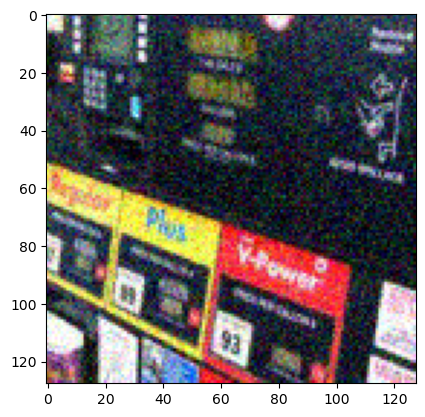

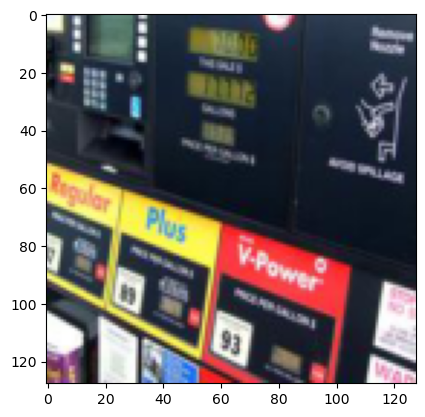

In [415]:
for i, (f,g) in enumerate(train_loader):
    plt.imshow(f[0].permute(1,2,0))
    plt.figure()
    plt.imshow(g[0].permute(1,2,0))
    break

In [416]:
def train_autoencoder(
    num_epochs,
    model,
    optimizer,
    train_loader,
    val_loader,
    early_stopping_epochs,
    save_model=None,
):
    losses = []
    val_losses = []
    outputs = []
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        running_losses = []
        for batch_idx, (noise_features , clean_features) in enumerate(train_loader):
            noise_features = noise_features.to(device)
            clean_features = clean_features.to(device)
            output = model(noise_features)
            loss = loss_function(output, clean_features)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_losses.append(loss.item())
        losses.append(np.mean(running_losses))

        model.eval()
        with torch.no_grad():
            running_val_loss = []
            for i, (noise_val_feature, clean_val_feature) in enumerate(val_loader):
                noise_val_feature = noise_val_feature.to(device)
                clean_val_feature = clean_val_feature.to(device)
                val_output = model(noise_val_feature)
                val_loss = loss_function(val_output, clean_val_feature)
                running_val_loss.append(val_loss.item())
            val_losses.append(np.mean(running_val_loss))

        print(
            "Epoch: %03d/%03d | Train Loss: %.4f | Val Loss: %.4f"
            % (
                epoch + 1,
                num_epochs,
                np.mean(running_losses),
                np.mean(running_val_loss),
            )
        )
        outputs.append([epoch, noise_features, output])

        if len(val_losses) > early_stopping_epochs:
            if val_losses[-1] >= val_losses[-early_stopping_epochs - 1]:
                print(
                    f"Early Stopping... {val_losses[-1]} ; {val_losses[-early_stopping_epochs-1]}"
                )
                model.load_state_dict(
                    torch.load(f"epoch{epoch-1}.pt", weights_only=True)
                )
                break

        torch.save(model.state_dict(), f"epoch{epoch}.pt")

    print("Total Training Time: %.2f min" % ((time.time() - start_time) / 60))
    if save_model is not None:
        torch.save(model.state_dict(), save_model)
    return losses, val_losses, outputs

def plot_latent(model, test_loader):
    latents = []
    labels = []
    for batch_idx, (features, label) in enumerate(test_loader):
        model.eval()
        latent = model.encode(features).detach().numpy()
        label = label.detach().numpy()
        latents.extend(latent)
        labels.extend(label)

    for idx, point in enumerate(latents):
        plt.scatter(point[0], point[1], marker=".", s=20, color=mcolors[labels[idx]])
    plt.show()


def plot_loss_curve(losses, val_losses):
    plt.title("Loss curve")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.plot(losses, label="Train loss")
    plt.plot(val_losses, label="Validation loss")
    plt.legend()
    plt.show()


def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [417]:
losses, val_losses, outputs = train_autoencoder(
    num_epochs=NUM_EPOCHS,
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    early_stopping_epochs=EARLY_STOPPING_EPOCHS,
    save_model="model1.pt",
)

Epoch: 001/020 | Train Loss: 0.0588 | Val Loss: 0.0237
Epoch: 002/020 | Train Loss: 0.0552 | Val Loss: 0.0226
Epoch: 003/020 | Train Loss: 0.0553 | Val Loss: 0.0230
Epoch: 004/020 | Train Loss: 0.0545 | Val Loss: 0.0246
Epoch: 005/020 | Train Loss: 0.0546 | Val Loss: 0.0241
Epoch: 006/020 | Train Loss: 0.0548 | Val Loss: 0.0216
Epoch: 007/020 | Train Loss: 0.0542 | Val Loss: 0.0192
Epoch: 008/020 | Train Loss: 0.0546 | Val Loss: 0.0197
Epoch: 009/020 | Train Loss: 0.0542 | Val Loss: 0.0171
Epoch: 010/020 | Train Loss: 0.0546 | Val Loss: 0.0177
Epoch: 011/020 | Train Loss: 0.0537 | Val Loss: 0.0167
Epoch: 012/020 | Train Loss: 0.0544 | Val Loss: 0.0198
Epoch: 013/020 | Train Loss: 0.0546 | Val Loss: 0.0190
Epoch: 014/020 | Train Loss: 0.0538 | Val Loss: 0.0206
Epoch: 015/020 | Train Loss: 0.0548 | Val Loss: 0.0199
Epoch: 016/020 | Train Loss: 0.0544 | Val Loss: 0.0226
Epoch: 017/020 | Train Loss: 0.0544 | Val Loss: 0.0213
Epoch: 018/020 | Train Loss: 0.0546 | Val Loss: 0.0212
Epoch: 019

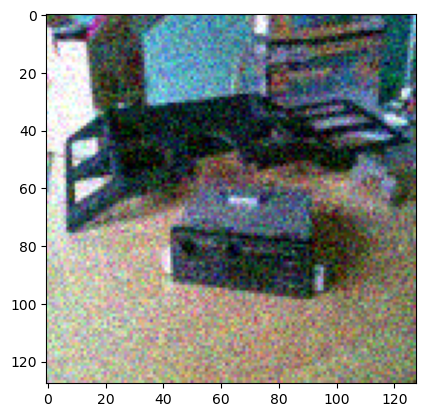

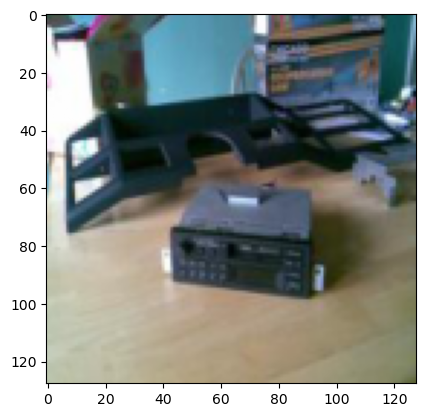

In [418]:
for i, (f,g) in enumerate(test_loader):
    plt.imshow(f[0].permute(1,2,0))
    plt.figure()
    plt.imshow(g[0].permute(1,2,0))
    break

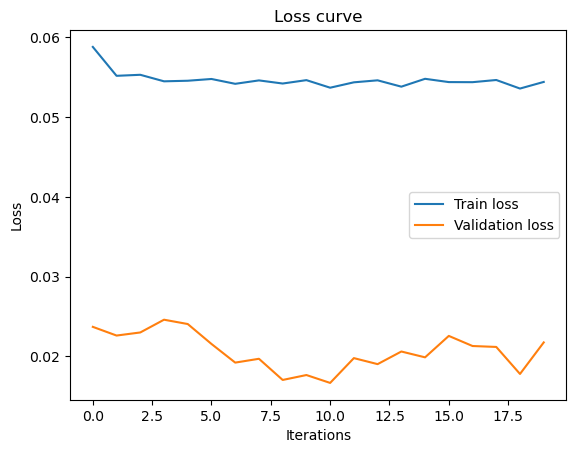

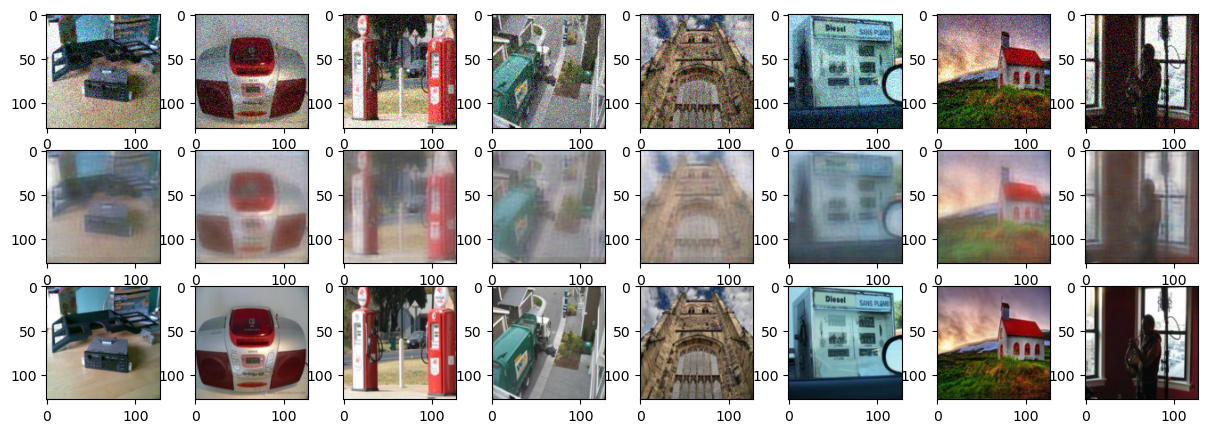

Test Loss: 0.021654168170369494
Average SSIM: 0.500614583492279
Average PSNR: 16.96150641493956


In [419]:
# plot_latent(model=model, test_loader=test_loader)
plot_loss_curve(losses, val_losses)

f, ax = plt.subplots(3, BATCH_SIZE, figsize=(15, 5))
model.eval()
with torch.no_grad():
    test_losses = []
    ssim = []
    psnr = []
    for batch_idx, (noise_test_features, clean_test_features) in enumerate(test_loader):
        
        noise_test_features = noise_test_features.to(device)
        clean_test_features = clean_test_features.to(device)
        test_output = model(noise_test_features)
        # compr = model.encode(test_features)
        test_loss = loss_function(test_output, clean_test_features)
        test_losses.append(test_loss.item())
        for idx,img in enumerate(clean_test_features):
            gt_image = np.transpose(img.cpu().numpy(), (1, 2, 0))
            if batch_idx==0:
                plt.imsave(f"groundTruth{idx}.png", gt_image)   
                ax[2, idx].imshow(gt_image)
        
        for idx,img in enumerate(noise_test_features):
            gt_image = np.transpose(clean_test_features[idx].cpu().numpy(), (1, 2, 0))

            
            input_image = np.transpose(img.cpu().numpy(), (1, 2, 0))
            output_image = np.transpose(
                test_output[idx].cpu().detach().numpy(), (1, 2, 0)
            )

            # compr_image = sigmoid(np.transpose(compr[idx].cpu().detach().numpy(),(1,2,0)))
            ssim.append(
                structural_similarity(
                    gt_image, output_image, data_range=1, channel_axis=2
                )
            )
            psnr.append(
                peak_signal_noise_ratio(gt_image, output_image, data_range=1)
            )

            if batch_idx == 0:
                input_image = input_image / np.max(input_image)
                output_image = output_image / np.max(output_image)
                plt.imsave(f"original{idx}.png", input_image)
                plt.imsave(f"output{idx}.png", output_image)
                plt.imsave(f"groundTruth{idx}.png", gt_image)   
                ax[2, idx].imshow(gt_image)

                ax[0, idx].imshow(input_image)
                # ax[1, idx].imshow(compr_image)
                ax[1, idx].imshow(output_image)

    #break


plt.show()
print(f"Test Loss: {np.mean(test_losses)}")
print(f"Average SSIM: {np.mean(ssim)}")
print(f"Average PSNR: {np.mean(psnr)}")
    